In [1]:
import numpy as np
from scipy.io import loadmat
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,explained_variance_score
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import load_boston
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense,Dropout
import keras
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

/home/sergei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
scaler = StandardScaler()
forest = RandomForestRegressor(n_estimators=100,n_jobs=-1)
linreg = LinearRegression(normalize=True)
boosting = LGBMRegressor()
pca = PCA(3)

## Цель вычислительного эксперимента:
Необходимо решить задачу регрессии с использованием моделей: линейная регрессия, линейная регрессия + метод главных компонент, простая нейросеть и критериями качества: квадратичная ошибка, число обусловленности.
## Описание выборок:
Используется датасет ECoG (electrocorticographic data), уже разбитый на выборки обучение/контроль.
## Блок загрузки и предобработки выборок:

In [45]:
X_train = loadmat('ECoG_X_train.mat')['X_train']
y_train = loadmat('ECoG_Y_train.mat')['Y_train']
X_test = loadmat('ECoG_X_test.mat')['X_hold_out']
y_test = loadmat('ECoG_Y_test.mat')['Y_hold_out']

In [46]:
X_train.shape

(12801, 32, 27)

In [47]:
y_train.shape

(12801, 3)

In [48]:
X_test.shape

(6087, 32, 27)

In [49]:
y_test.shape

(6087, 3)

Объектами X_train, X_test являются матрицы 32x27. Преобразуем их в одномерные векторы:

In [50]:
X_train = np.array([i.flatten() for i in X_train])
X_test = np.array([i.flatten() for i in X_test])

## Анализ пропусков

In [51]:
np.isnan(X_train).any()

False

In [52]:
np.isnan(y_train).any()

False

Данная выборка не имеет пропусков.

## Список моделей
Для решения поставленной задачи используются следующие модели:
* линейная регрессия
* PCA + линейная регрессия
* простая нейросеть 

## Список критериев качетсва:
* mean squared error
* variance score

## Структурные параметры нейронной сети:
* число и состав признаков
* размерность скрытого пространства
* структура сети

## Способ разбиения выборки на обучение-контроль:
Данные уже разбиты на 2 выборки.

## Линейная регрессия:

In [53]:
model = linreg
pipe = Pipeline(steps=[('model', model)])

In [54]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [55]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

1786.7787691924393 0.0703714702511374


## Линейная регрессия c PCA до 80 компонент

In [56]:
model = linreg
pca = PCA(n_components=80)
pipe = Pipeline(steps=[('pca',pca),('model', model)])

In [57]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [16]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

1634.9021249309262 0.14720602892118914


## Нейронная сеть

In [17]:
def big_model():
    model = Sequential()
    model.add(Dense(512, input_dim=864, kernel_initializer='normal', 
                    activation='relu',kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(256, kernel_initializer='normal', activation='relu',
                   kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(Dense(3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [18]:
neural_net = KerasRegressor(big_model,epochs=100, batch_size=200,verbose=1)
model = neural_net
pipe = Pipeline(steps=[('scaler',scaler),('model', model)])

In [19]:
pipe.fit(X_train,y_train)

Epoch 1/100
12801/12801 [==============================] - 2s 193us/step - loss: 13267.5586
Epoch 2/100
12801/12801 [==============================] - 2s 183us/step - loss: 4041.5849
Epoch 3/100
12801/12801 [==============================] - 2s 176us/step - loss: 3281.9153
Epoch 4/100
12801/12801 [==============================] - 3s 204us/step - loss: 2944.1734
Epoch 5/100
12801/12801 [==============================] - 2s 147us/step - loss: 2679.5288
Epoch 6/100
12801/12801 [==============================] - 2s 145us/step - loss: 2532.5210
Epoch 7/100
12801/12801 [==============================] - 2s 146us/step - loss: 2353.0209
Epoch 8/100
12801/12801 [==============================] - 2s 145us/step - loss: 2239.8293
Epoch 9/100
12801/12801 [==============================] - 2s 147us/step - loss: 2128.6700
Epoch 10/100
12801/12801 [==============================] - 2s 144us/step - loss: 2026.7586
Epoch 11/100
12801/12801 [==============================] - 2s 145us/step - loss: 1950.8

12801/12801 [==============================] - 2s 145us/step - loss: 402.9116
Epoch 91/100
12801/12801 [==============================] - 2s 146us/step - loss: 403.3715
Epoch 92/100
12801/12801 [==============================] - 2s 142us/step - loss: 408.8777
Epoch 93/100
12801/12801 [==============================] - 2s 144us/step - loss: 379.6226
Epoch 94/100
12801/12801 [==============================] - 2s 144us/step - loss: 385.9344
Epoch 95/100
12801/12801 [==============================] - 2s 143us/step - loss: 386.4764
Epoch 96/100
12801/12801 [==============================] - 2s 142us/step - loss: 388.6228
Epoch 97/100
12801/12801 [==============================] - 2s 145us/step - loss: 370.1514
Epoch 98/100
12801/12801 [==============================] - 2s 142us/step - loss: 384.8814
Epoch 99/100
12801/12801 [==============================] - 2s 143us/step - loss: 366.2080
Epoch 100/100
12801/12801 [==============================] - 2s 147us/step - loss: 376.1069


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f34b991de10>)])

In [20]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

6087/6087 [==============================] - 0s 51us/step
2201.432127414498 -0.23993686219468283


## Графики

##### Зависимость функции ошибки от количества эпох

In [59]:
results = []
for n_epoch in [1,5,10,20,50]:
    model = KerasRegressor(big_model,epochs=n_epoch, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    results.append(error)

In [60]:
results

[4630.198038338352,
 4201.092629025311,
 2747.6852008061674,
 3935.4696264252325,
 2219.050701555916]

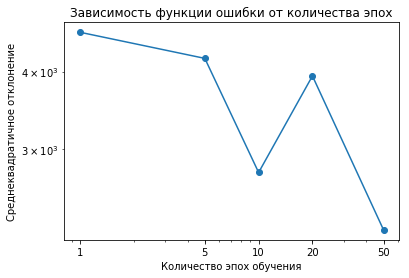

In [61]:
x_ticks = [1,5,10,20,50]
fig, ax = plt.subplots()
plt.scatter(x_ticks,results)
plt.plot(x_ticks,results)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks)
ax.set_title('Зависимость функции ошибки от количества эпох')
ax.set_xlabel("Количество эпох обучения")
ax.set_ylabel("Среднеквадратичное отклонение")
plt.show()

##### Зависимость функции ошибки от размера скрытого слоя

In [63]:
def variable_model():
    model = Sequential()
    model.add(Dense(64, input_dim=864, kernel_initializer='normal', activation='relu'))
    for i in range(n_l-1):
        model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model
results1 = []
n_layers = [1,2,3]
for n_l in n_layers:
    model = KerasRegressor(variable_model,epochs=10, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    results1.append(error)    

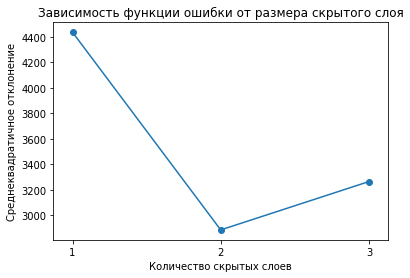

In [66]:
fig, ax = plt.subplots()
ax.set_xlabel("Количество скрытых слоев")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(n_layers)
plt.scatter(n_layers,results1)
plt.plot(n_layers,results1)
plt.show()

In [65]:
results1

[4434.4494121612, 2883.9089634441157, 3263.127377577308]

##### Зависимость функции ошибки от размера обучающей выборки

In [67]:
percents_of_data = [0.1,0.2,0.3,0.5,0.8,1.0]
results3 = []
for pod in percents_of_data:
    model = KerasRegressor(big_model,epochs=10, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train[:int(len(X_train)*pod)],y_train[:int(len(X_train)*pod)])
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    results3.append(error)

In [68]:
results3

[9203.117221489736,
 3793.6104916949575,
 3646.345507714925,
 2908.968609685198,
 2195.6731824978456,
 3373.491829821394]

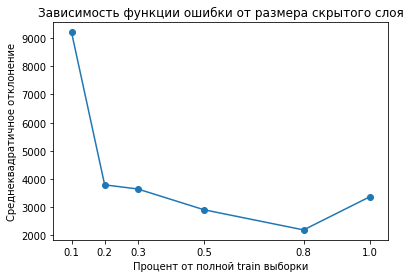

In [70]:
fig, ax = plt.subplots()
#ax.set_ylim(0,60)
ax.set_xlabel("Процент от полной train выборки")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(percents_of_data)
plt.scatter(percents_of_data,results3)
plt.plot(percents_of_data,results3)
plt.show()

## Анализ результатов

|                    | linreg  | linreg + PCA | neural_net |
|--------------------|---------|--------------|------------|
| mean squared error | 1786.77 | 1634.90      | 2201.43    | 
| variance score     | 0.070   | 0.147        | -0.240     |

# Синтетическая выборка
В качестве синтетической выборки для задачи регрессии возьмём Boston dataset.

In [22]:
dataset = load_boston()

In [23]:
dataset.data.shape

(506, 13)

In [24]:
y = dataset.target
X = dataset.data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=228)

## Линейная регрессия

In [25]:
model = linreg
pipe = Pipeline(steps=[('model', model)])

In [26]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [27]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

31.84400099655244 0.7013949934877279


## Линейная регрессия c PCA до 8 компонент

In [28]:
model = linreg
pca = PCA(n_components=8)
pipe = Pipeline(steps=[('pca',pca),('model', model)])

In [29]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('model', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True))])

In [30]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

49.06022977053876 0.5449917208136847


## Нейронная сеть

In [31]:
def small_model():
    model = Sequential()
    model.add(Dense(128, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model

In [32]:
neural_net = KerasRegressor(small_model,epochs=200, batch_size=100,verbose=0)
model = neural_net
pipe = Pipeline(steps=[('scaler',scaler),('model', model)])

In [33]:
pipe.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f34a2f552b0>)])

In [34]:
res = pipe.predict(X_test)
mse = mean_squared_error(res,y_test) 
varience = explained_variance_score(y_test,res)
print(mse,varience)

11.487555915710486 0.8959702106841729


## Графики

##### Зависимость функции ошибки от количества эпох

In [35]:
results = []
for n_epoch in [1,5,10,20,50,100,200,500]:
    model = KerasRegressor(small_model,epochs=n_epoch, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    results.append(error)

In [36]:
results

[653.4952837205167,
 560.2870466981225,
 374.655238670085,
 78.95173029535201,
 20.1937801607061,
 13.443411635658446,
 11.38688666630073,
 9.433251179245094]

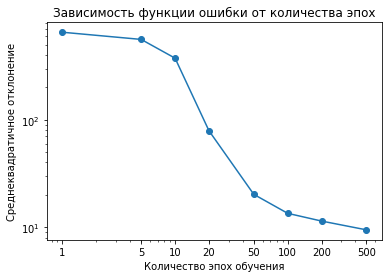

In [37]:
x_ticks = [1,5,10,20,50,100,200,500]
fig, ax = plt.subplots()
plt.scatter(x_ticks,results)
plt.plot(x_ticks,results)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticks)
ax.set_title('Зависимость функции ошибки от количества эпох')
ax.set_xlabel("Количество эпох обучения")
ax.set_ylabel("Среднеквадратичное отклонение")
plt.show()

##### Зависимость функции ошибки от размера скрытого слоя

In [38]:
def variable_model():
    model = Sequential()
    model.add(Dense(64, input_dim=13, kernel_initializer='normal', activation='relu'))
    for i in range(n_l-1):
        model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    return model
results1 = []
n_layers = [1,2,3,5,10]
for n_l in n_layers:
    model = KerasRegressor(variable_model,epochs=200, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train,y_train)
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    results1.append(error)    

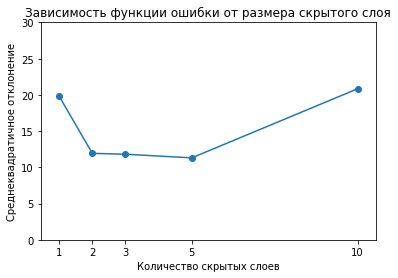

In [39]:
fig, ax = plt.subplots()
ax.set_ylim(0,30)
ax.set_xlabel("Количество скрытых слоев")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(n_layers)
plt.scatter(n_layers,results1)
plt.plot(n_layers,results1)
plt.show()

In [40]:
results1

[19.8219369137061,
 11.92726829917833,
 11.807926988618771,
 11.30515699593905,
 20.834598771448352]

##### Зависимость функции ошибки от размера обучающей выборки

In [41]:
percents_of_data = [0.1,0.2,0.3,0.5,0.8,1.0]
results3 = []
for pod in percents_of_data:
    #sample = np.random.choice(np.arange(len(X_train)),size=int(len(X_train)*pod),replace=False)
    model = KerasRegressor(small_model,epochs=100, batch_size=100,verbose=0)
    pipe = Pipeline(steps=[('scaler',scaler),('model', model)])
    pipe.fit(X_train[:int(len(X_train)*pod)],y_train[:int(len(X_train)*pod)])
    res = pipe.predict(X_test)
    error = mean_squared_error(res,y_test) 
    results3.append(error)

In [42]:
results3

[56.26780305575717,
 48.00847853404851,
 26.1792784524941,
 21.29861561770024,
 17.990109251874816,
 12.748664259380307]

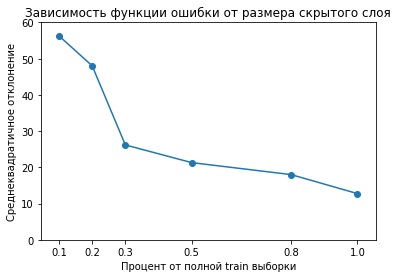

In [43]:
fig, ax = plt.subplots()
ax.set_ylim(0,60)
ax.set_xlabel("Процент от полной train выборки")
ax.set_ylabel("Среднеквадратичное отклонение")
ax.set_title('Зависимость функции ошибки от размера скрытого слоя')
ax.set_xticks(percents_of_data)
plt.scatter(percents_of_data,results3)
plt.plot(percents_of_data,results3)
plt.show()